# Urbansed

In [1]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [2]:
# Import used libraries
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [3]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 0.04,
    hop_len: float = 0.01,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        hop_length=hop_len*audio.sr,
        x_axis="s",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## Dataset

In [4]:
from yoho.train import load_dataset
from yoho.utils import UrbanSEDDataset

urbansed_train = load_dataset(partition="train")
urbansed_val = load_dataset(partition="validate")

print(f"Number of audio clips in the train dataset: {len(urbansed_train)}")
print(f"Number of audio clips in the validation dataset: {len(urbansed_val)}")
print(f"Duration of each audio clips: {urbansed_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {urbansed_train.audios[0].sr} Hz")

INFO:root:Loading the train dataset from the pickle file
INFO:root:Loading the validation dataset from the pickle file


Number of audio clips in the train dataset: 54000
Number of audio clips in the validation dataset: 18000
Duration of each audio clips: 2.56 seconds
Sampling rate of each audio clips: 44100 Hz


## Data generator

In [5]:
from yoho.utils import YOHODataGenerator

val_dataloader = YOHODataGenerator(
    urbansed_val, batch_size=32, shuffle=False
)

val_features, val_labels = next(iter(val_dataloader))

print(f"Test features shape: {val_features.shape}")
print(f"Test labels shape: {val_labels.shape}")

Test features shape: torch.Size([32, 1, 40, 257])
Test labels shape: torch.Size([32, 30, 9])


## YOHO model

In [6]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
urbansed_model = YOHO(
    name="UrbanSEDYOHO",
    input_shape=(1, 40, 257), n_classes=len(urbansed_train.labels)
).to(device)

urbansed_model.load(f"./models/{urbansed_model.name}_checkpoint.pth.tar", device)

summary(
    urbansed_model,
    input_size=(1, 40, 257),
    batch_size=32,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 32, 20, 129]             288
       BatchNorm2d-2          [32, 32, 20, 129]              64
              ReLU-3          [32, 32, 20, 129]               0
            Conv2d-4          [32, 32, 20, 129]             288
       BatchNorm2d-5          [32, 32, 20, 129]              64
              ReLU-6          [32, 32, 20, 129]               0
            Conv2d-7          [32, 64, 20, 129]           2,112
       BatchNorm2d-8          [32, 64, 20, 129]             128
              ReLU-9          [32, 64, 20, 129]               0
        Dropout2d-10          [32, 64, 20, 129]               0
DepthwiseSeparableConv-11          [32, 64, 20, 129]               0
           Conv2d-12           [32, 64, 10, 65]             576
      BatchNorm2d-13           [32, 64, 10, 65]             128
             ReLU-14           [32

## Evaluation
### Train and validation losses

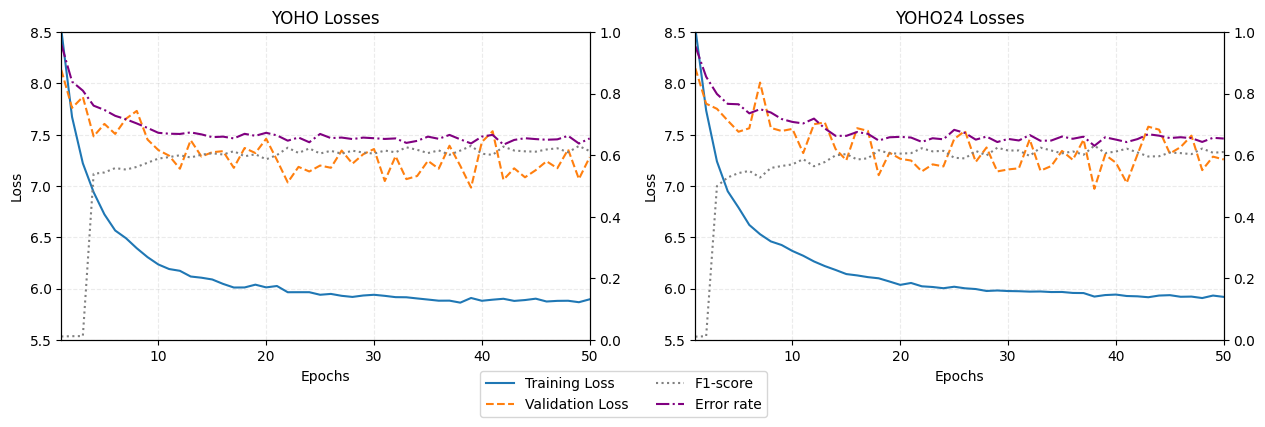

In [7]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/UrbanSEDYOHO_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []
f1_scores = []
error_rates = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])
    f1_scores.append(metrics["f1_score"])
    error_rates.append(metrics["error_rate"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].set_title("YOHO Losses")
ax[0].plot(epochs, train_losses, label="Training Loss")
ax[0].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(1, 50)
ax[0].set_ylim(5.5,8.5)
ax[0].grid(alpha=.25, linestyle='--')

ax_1 = ax[0].twinx()
ax_1.plot(epochs, f1_scores, label="F1-score", linestyle=":", color='grey')
ax_1.plot(epochs, error_rates, label="Error rate", linestyle="-.", color='purple')

ax_1.set_ylim(0, 1)

with open("./models/UrbanSEDYOHO24_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []
f1_scores = []
error_rates = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])
    f1_scores.append(metrics["f1_score"])
    error_rates.append(metrics["error_rate"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

ax[1].set_title("YOHO24 Losses")
ax[1].plot(epochs, train_losses, label="Training Loss")
ax[1].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xlim(1,50)
ax[1].set_ylim(5.5,8.5)
ax[1].grid(alpha=.25, linestyle='--')

ax_1 = ax[1].twinx()
ax_1.plot(epochs, f1_scores, label="F1-score", linestyle=":", color='grey')
ax_1.plot(epochs, error_rates, label="Error rate", linestyle="-.", color='purple')

ax_1.set_ylim(0, 1)

# Get ax[0] and ax[0].twinx() legend handles and labels
handles0, labels0 = ax[1].get_legend_handles_labels()
handles1, labels1 = ax_1.get_legend_handles_labels()
fig.legend(handles0 + handles1, labels0 + labels1, loc='lower center', ncol=2, bbox_to_anchor=(0.5,-0.1))

plt.show()

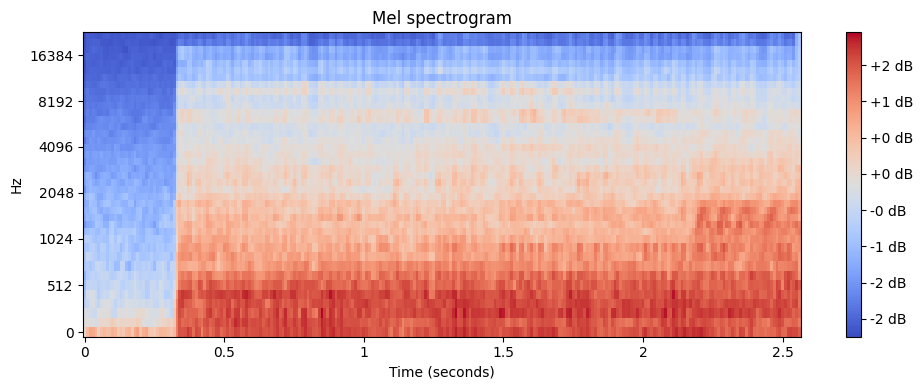

In [8]:
plot_melspectrogram(urbansed_val.audios[41])

In [9]:
predictions = urbansed_model(val_features.to(device))
targets = val_labels.to(device)

In [10]:
import numpy as np


def process_output(
    output: np.array, classes: list[str]
) -> list[tuple[str, float, float]]:

    STEPS_NO = 9
    step_duration = 2.56 / STEPS_NO
    MIN_EVENT_DURATION = 0
    MIN_SILENCE_DURATION = 1.0

    processed_output = []

    for k in range(output.shape[0]):

        labels = []
        for i in range(output.shape[2]):

            for j in range(0, output.shape[1], 3):
                if output[k, j, i] >= 0.5:
                    label = classes[j // 3]
                    start = (
                        i * step_duration
                        + output[k, j + 1, i].item() * step_duration
                    )
                    end = (
                        i * step_duration
                        + output[k, j + 2, i].item() * step_duration
                    )
                    labels.append((label, round(start, 2), round(end, 2)))

        # Order the labels by class
        labels = sorted(labels, key=lambda x: x[0])

        # Merge events of the same class that are close to each other
        merged_labels = []
        for label, start, end in labels:
            if not merged_labels:
                merged_labels.append((label, start, end))
            else:
                prev_label, prev_start, prev_end = merged_labels[-1]
                if (
                    prev_label == label
                    and start - prev_end < MIN_SILENCE_DURATION
                ):
                    merged_labels[-1] = (label, prev_start, end)
                else:
                    merged_labels.append((label, start, end))

        # Remove events that are too short
        merged_labels = [
            (label, start, end)
            for label, start, end in merged_labels
            if end - start >= MIN_EVENT_DURATION
        ]

        # Order the labels by start time
        # If two events start at the same time, order by class index
        merged_labels = sorted(
            merged_labels, key=lambda x: (x[1], classes.index(x[0]))
        )

        processed_output.append(merged_labels)

    return processed_output

print(
    process_output(targets, urbansed_train.labels), 
    process_output(predictions, urbansed_train.labels), sep="\n"
)

[[('street_music', 1.72, 2.56), ('gun_shot', 2.1, 2.56)], [('street_music', 0.72, 1.84), ('gun_shot', 1.1, 2.16)], [('street_music', 0.0, 0.84), ('gun_shot', 0.1, 1.16), ('street_music', 2.42, 2.56)], [('gun_shot', 0.0, 0.16), ('street_music', 1.42, 2.56)], [('street_music', 0.42, 1.86)], [('street_music', 0.0, 0.86)], [], [], [], [('dog_bark', 1.52, 2.52)], [('dog_bark', 0.52, 1.52)], [('dog_bark', 0.0, 0.52), ('jackhammer', 2.37, 2.56)], [('jackhammer', 1.37, 2.56)], [('jackhammer', 0.37, 2.56)], [('jackhammer', 0.0, 2.56)], [('jackhammer', 0.0, 2.17), ('air_conditioner', 2.22, 2.56)], [('jackhammer', 0.0, 1.17), ('air_conditioner', 1.22, 2.56)], [('jackhammer', 0.0, 0.17), ('air_conditioner', 0.22, 1.76)], [], [('car_horn', 1.97, 2.56), ('gun_shot', 2.14, 2.56)], [('car_horn', 0.97, 2.56), ('gun_shot', 1.14, 1.99)], [('car_horn', 0.0, 2.56), ('gun_shot', 0.14, 0.99), ('drilling', 1.82, 2.56)], [('car_horn', 0.0, 2.56), ('drilling', 0.82, 2.31)], [('car_horn', 0.0, 2.56), ('drilling'

In [11]:
def get_test_set():
    urbansed_test = UrbanSEDDataset(
        audios=[
            audioclip
            for _, audio in enumerate(
                AudioFile(filepath=file.filepath, labels=eval(file.events))
                for _, file in pd.read_csv(
                    "./data/raw/UrbanSED/test.csv"
                ).iterrows()
            )
            for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
        ]
    )
    return urbansed_test


urbansed_test = get_test_set()

In [12]:
urbansed_test_dataloader = YOHODataGenerator(
    urbansed_test, batch_size=32, shuffle=False
)

In [13]:
import sed_eval
import dcase_util

def compute_metrics(predictions, targets, classes, filepaths):
    """
    Computes the error rate and F1 score for the given predictions and targets.
    """

    # Process the outputs
    processed_predictions = process_output(predictions.cpu().numpy(), classes)
    processed_targets = process_output(targets.cpu().numpy(), classes)

    temp_f1 = 0
    temp_error = 0

    total_f1_score = 0
    total_error_rate = 0

    N_events = 0


    segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=classes,
        time_resolution=1.0,
    )

    for pred, target, filepath in zip(
        processed_predictions, processed_targets, filepaths
    ):
        
        if not pred and not target:
            temp_f1 += 1
            temp_error += 0
            continue

        if pred and not target:
            temp_f1 += 0
            temp_error += 1
            continue
        
        if not pred and target:
            temp_f1 += 0
            temp_error += 1
            N_events += len(target)
            continue


        if pred and target:
            N_events += len(target)

            
            # Create the event list
            pred_event_list = dcase_util.containers.MetaDataContainer(
                [
                    {
                        "file": filepath,
                        "event_label": event[0],
                        "onset": event[1],
                        "offset": event[2],
                    }
                    for event in pred
                ]
            )

            # Create the target event list
            target_event_list = dcase_util.containers.MetaDataContainer(
                [
                    {
                        "file": filepath,
                        "event_label": event[0],
                        "onset": event[1],
                        "offset": event[2],
                    }
                    for event in target
                ]
            )

            segment_based_metrics.evaluate(
                reference_event_list=target_event_list,
                estimated_event_list=pred_event_list,
            )

        

    overall_metrics = segment_based_metrics.results_overall_metrics()

    temp_error = temp_error / N_events
    temp_f1 = temp_f1 / N_events

    if np.isnan(overall_metrics["f_measure"]["f_measure"]):
        total_f1_score = temp_f1
    else:
        total_f1_score = overall_metrics["f_measure"]["f_measure"] + temp_f1

    total_error_rate = overall_metrics["error_rate"]["error_rate"] + temp_error

    return total_error_rate, total_f1_score

In [14]:
error_rate = 0.0
f1_score = 0.0
num_batches = 0

with torch.no_grad():

    for _, (inputs, labels) in enumerate(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = urbansed_model(inputs)

        filepaths = [
            audio.filepath
            for audio in urbansed_test_dataloader.dataset.audios[
                _
                * urbansed_test_dataloader.batch_size : (_ + 1)
                * urbansed_test_dataloader.batch_size
            ]
        ]

        # Compute the error rate and f1 score
        running_error_rate, running_f1_score = compute_metrics(
            predictions=outputs,
            targets=labels,
            classes=urbansed_test_dataloader.dataset.labels,
            filepaths=filepaths,
        )

        error_rate += running_error_rate
        f1_score += running_f1_score
        num_batches += 1

        print(f"Batch {num_batches} - Error rate: {running_error_rate:.2f}, F1 score: {running_f1_score:.2f}")

        if num_batches == 10:
            break


# Now, instead of dividing by the length of the dataloader, divide by the actual number of batches processed
error_rate /= num_batches
f1_score /= num_batches

print(f"Total Error rate: {error_rate:.2f}")
print(f"Total F1 score: {f1_score:.2f}")


Batch 1 - Error rate: 0.75, F1 score: 0.47
Batch 2 - Error rate: 0.70, F1 score: 0.48
Batch 3 - Error rate: 0.88, F1 score: 0.70
Batch 4 - Error rate: 0.62, F1 score: 0.64
Batch 5 - Error rate: 0.63, F1 score: 0.54
Batch 6 - Error rate: 0.67, F1 score: 0.59
Batch 7 - Error rate: 0.64, F1 score: 0.55


KeyboardInterrupt: 